(252, 252) 117.852796674
[[ 0.60653066  0.67348826  0.7021885   0.67348826  0.60653066]
 [ 0.67348826  0.77880078  0.83796689  0.77880078  0.67348826]
 [ 0.7021885   0.83796689  1.          0.83796689  0.7021885 ]
 [ 0.67348826  0.77880078  0.83796689  0.77880078  0.67348826]
 [ 0.60653066  0.67348826  0.7021885   0.67348826  0.60653066]]
(76, 76)


F:\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


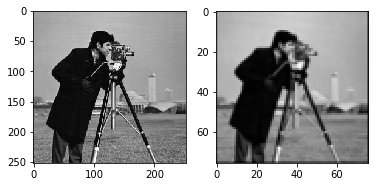

In [1]:
%matplotlib inline
import numpy as np
import os, string
from matplotlib import pyplot as plt
import scipy as sp
import cv2
import tensorflow as tf

img = cv2.imread('camera.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
print(img.shape,img.mean())
dia = 5
#blurKernel = np.ones((dia,dia))/(dia**2.)
blurKernel = np.zeros((dia, dia))
center = (dia-1) / 2
R = np.sqrt(center**2 + center**2)
for i in range(5):
    for j in range(5):
        dis = np.sqrt((i-center)**2+(j-center)**2)
        blurKernel[i, j] = np.exp(-0.5*dis/R)
        
print(blurKernel)

from scipy import signal#warning
blurImg = signal.convolve2d(img, blurKernel, mode='same')
blurImg = cv2.resize(blurImg,(0,0),fx=0.3,fy=0.3)
print(blurImg.shape)
fig = plt.figure()
ax = fig.add_subplot(121)  
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)  
ax.imshow(blurImg,cmap='gray')
fig.show()

In [5]:
with tf.device('/gpu:0'):
    initial = tf.random_normal([1,252,252,1]) * 0.256
    X = tf.Variable(initial)
    A=tf.placeholder("float", shape=[dia,dia,1,1])
    B=tf.placeholder("float", shape=[1,76,76,1])
    mu = 0.01
    #loss = tf.image.resize_images(X, [76, 76], tf.image.ResizeMethod.BILINEAR)
    #loss = tf.nn.conv2d(loss,A,strides=[1,1,1,1],padding='SAME')
    loss = tf.nn.conv2d(X,A,strides=[1,1,1,1],padding='SAME')
    loss = tf.image.resize_images(loss, [76, 76], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #loss = tf.nn.conv2d(loss,A,strides=[1,1,1,1],padding='SAME')
    loss = loss - B
    loss = tf.reshape(loss,[76*76,-1])
    X_ravel = tf.reshape(B,[76*76,-1])
    loss = tf.nn.l2_loss(loss)+mu*tf.nn.l2_loss(X_ravel-118.)#L2#tf.reduce_mean(tf.abs(X_ravel-118.))

In [6]:
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
sess = tf.Session()
#print(sess)
init = tf.global_variables_initializer()
sess.run(init)
blurImg_ravel = blurImg.reshape([76,76,1,1])
blurImg_ravel = blurImg_ravel.transpose(3,0,1,2)
blurKernel_ravel = blurKernel.reshape([dia,dia,1,1])
for step in range(901):
    sess.run(train_op,feed_dict={A: blurKernel_ravel, B:blurImg_ravel})
    if step % 100 == 0:
        print('epoch:',step)

res = sess.run(X)
print(res.shape)

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
(1, 252, 252, 1)


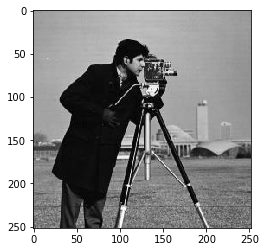

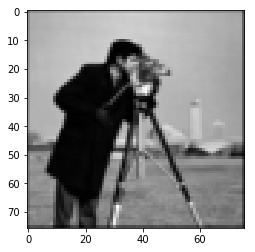

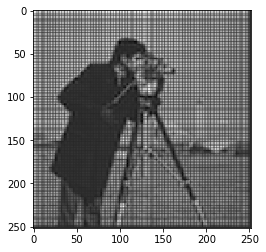

In [7]:
resImg = res.transpose([1,2,3,0])
resImg = resImg.reshape([252,252])
fig = plt.figure()
plt.imshow(img,cmap='gray')
fig = plt.figure()
plt.imshow(blurImg,cmap='gray')
fig = plt.figure()
plt.imshow(resImg,cmap='gray')
plt.show()

In [16]:
Gauss_map = np.zeros((5, 5))
R = np.sqrt(2**2 + 2**2)
for i in range(5):
    for j in range(5):
        dis = np.sqrt((i-2)**2+(j-2)**2)
        Gauss_map[i, j] = np.exp(-0.5*dis/R)
        
print(Gauss_map)

[[ 0.60653066  0.67348826  0.7021885   0.67348826  0.60653066]
 [ 0.67348826  0.77880078  0.83796689  0.77880078  0.67348826]
 [ 0.7021885   0.83796689  1.          0.83796689  0.7021885 ]
 [ 0.67348826  0.77880078  0.83796689  0.77880078  0.67348826]
 [ 0.60653066  0.67348826  0.7021885   0.67348826  0.60653066]]
